## Installations 🤖

In [1]:
!pip install aicrowd-cli pyarrow

  Using cached aicrowd_cli-0.1.15-py3-none-any.whl (51 kB)
  Using cached GitPython-3.1.18-py3-none-any.whl (170 kB)
  Using cached requests_toolbelt-0.10.1-py2.py3-none-any.whl (54 kB)
  Using cached python_slugify-5.0.2-py2.py3-none-any.whl (6.7 kB)
  Using cached gitdb-4.0.10-py3-none-any.whl (62 kB)
  Attempting uninstall: python-slugify
    Found existing installation: python-slugify 6.1.1
    Uninstalling python-slugify-6.1.1:
      Successfully uninstalled python-slugify-6.1.1


## Login to AIcrowd and download the data 📚

In [2]:
!aicrowd login

Please login here: https://api.aicrowd.com/auth/cvcRrzkcxOAtk3lrt71t4Ld-M9S2kKBQ2NKrN93ofAg
API Key valid
Gitlab access token valid
Saved details successfully!


In [3]:
!aicrowd dataset download --challenge task-1-next-product-recommendation


sessions_test_task1_phase1.csv:   0%|          | 0.00/19.4M [00:00<?, ?B/s]
sessions_test_task1_phase1.csv:   5%|5         | 1.05M/19.4M [00:01<00:27, 673kB/s]
sessions_test_task1_phase1.csv:  11%|#         | 2.10M/19.4M [00:02<00:19, 883kB/s]
sessions_test_task1_phase1.csv:  22%|##1       | 4.19M/19.4M [00:03<00:10, 1.48MB/s]
sessions_test_task1_phase1.csv:  32%|###2      | 6.29M/19.4M [00:04<00:08, 1.55MB/s]
sessions_test_task1_phase1.csv:  38%|###7      | 7.34M/19.4M [00:05<00:07, 1.63MB/s]
sessions_test_task1_phase1.csv:  43%|####3     | 8.39M/19.4M [00:05<00:05, 1.83MB/s]
sessions_test_task1_phase1.csv:  49%|####8     | 9.44M/19.4M [00:05<00:05, 1.96MB/s]
sessions_test_task1_phase1.csv:  54%|#####4    | 10.5M/19.4M [00:06<00:04, 2.18MB/s]
sessions_test_task1_phase1.csv:  60%|#####9    | 11.5M/19.4M [00:06<00:03, 2.37MB/s]
sessions_test_task1_phase1.csv:  65%|######4   | 12.6M/19.4M [00:07<00:02, 2.45MB/s]
sessions_test_task1_phase1.csv:  70%|#######   | 13.6M/19.4M [00:07<00:02, 

## Setup data and task information

In [397]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from functools import lru_cache
import matplotlib.pyplot as plt

In [304]:
train_data_dir = 'train_data'
test_data_dir = 'test_data'
task = 'task1'
PREDS_PER_SESSION = 100

In [305]:
# Cache loading of data for multiple calls

@lru_cache(maxsize=1)
def read_product_data():
    return pd.read_csv(os.path.join(train_data_dir, 'products_train.csv'))

@lru_cache(maxsize=1)
def read_train_data():
    return pd.read_csv(os.path.join(train_data_dir, 'sessions_train.csv'))

@lru_cache(maxsize=3)
def read_test_data(task):
    return pd.read_csv(os.path.join(test_data_dir, f'sessions_test_{task}.csv'))

## Data Description

The Multilingual Shopping Session Dataset is a collection of <b>anonymized customer sessions</b> containing products from six different locales, namely English, German, Japanese, French, Italian, and Spanish. It consists of two main components: user sessions and product attributes. User sessions are a list of products that a user has engaged with in chronological order, while product attributes include various details like product title, price in local currency, brand, color, and description.
****
### Each product has its associated information:
- <b>locale</b>: The locale code of the product.
- <b>id</b>: A unique id for the product.
- <b>title</b>: Title of the item (e.g., "Japanese Aesthetic Sakura Flowers Vaporwave Soft Grunge Gift T-Shirt")
- <b>price</b>: Price of the item in local currency (e.g., 24.99)
- <b>brand</b>: item brand name (e.g., “Japanese Aesthetic Flowers & Vaporwave Clothing”)
- <b>color</b>: color of the item (e.g., “Black”)
- <b>size</b>: size of the item (e.g., “xxl”)
- <b>model</b>: model of the item (e.g., “iphone 13”)
- <b>material</b>: material of the item (e.g., “cotton”)
- <b>author</b>: author of the item (e.g., “J. K. Rowling”)
- <b>desc</b>: description about a item’s key features and benefits called out via bullet points (e.g., “Solid colors: 100% Cotton; Heather Grey: 90% Cotton, 10% Polyester; All Other Heathers …”)

## EDA 📊

In [306]:
def read_locale_data(locale, task):
    products = read_product_data().query(f'locale == "{locale}"')
    sess_train = read_train_data().query(f'locale == "{locale}"')
    sess_test = read_test_data(task).query(f'locale == "{locale}"')
    return products, sess_train, sess_test

def show_locale_info(locale, task):
    products, sess_train, sess_test = read_locale_data(locale, task)

    train_l = sess_train['prev_items'].apply(lambda sess: len(sess))
    test_l = sess_test['prev_items'].apply(lambda sess: len(sess))

    print(f"Locale: {locale} \n"
          f"Number of products: {products['id'].nunique()} \n"
          f"Number of train sessions: {len(sess_train)} \n"
          f"Train session lengths - "
          f"Mean: {train_l.mean():.2f} | Median {train_l.median():.2f} | "
          f"Min: {train_l.min():.2f} | Max {train_l.max():.2f} \n"
          f"Number of test sessions: {len(sess_test)}"
        )
    if len(sess_test) > 0:
        print(
             f"Test session lengths - "
            f"Mean: {test_l.mean():.2f} | Median {test_l.median():.2f} | "
            f"Min: {test_l.min():.2f} | Max {test_l.max():.2f} \n"
        )
    print("======================================================================== \n")

In [307]:
products = read_product_data()
locale_names = products['locale'].unique()
for locale in locale_names:
    show_locale_info(locale, task)

Locale: DE 
Number of products: 518327 
Number of train sessions: 1111416 
Train session lengths - Mean: 57.89 | Median 40.00 | Min: 27.00 | Max 2060.00 
Number of test sessions: 104568
Test session lengths - Mean: 56.91 | Median 40.00 | Min: 27.00 | Max 1043.00 


Locale: JP 
Number of products: 395009 
Number of train sessions: 979119 
Train session lengths - Mean: 59.61 | Median 40.00 | Min: 27.00 | Max 6257.00 
Number of test sessions: 96467
Test session lengths - Mean: 59.84 | Median 40.00 | Min: 27.00 | Max 1466.00 


Locale: UK 
Number of products: 500180 
Number of train sessions: 1182181 
Train session lengths - Mean: 54.85 | Median 40.00 | Min: 27.00 | Max 2654.00 
Number of test sessions: 115937
Test session lengths - Mean: 53.25 | Median 40.00 | Min: 27.00 | Max 753.00 


Locale: ES 
Number of products: 42503 
Number of train sessions: 89047 
Train session lengths - Mean: 48.82 | Median 40.00 | Min: 27.00 | Max 792.00 
Number of test sessions: 0

Locale: FR 
Number of produ

In [20]:
products.sample(5)

,id,locale,title,price,brand,color,size,model,material,author,desc
1427524,B08QS5XR31,ES,Auxmir Espejo de Maquillaje con Aumento 1X / 7...,16.49,Auxmir,NaN,Espejo de mesa 1X/7X,‎,Vidrio,NaN,[ALTURA PERFECTA & MÁS CÓMODO]: El espejo maqu...
859608,B0BG3NV6TM,JP,【眼科医推薦】 C_himawari シャンプーハット バスグッズ お風呂 赤ちゃん 大人 ...,1450.00,C_himawari,ホワイト,NaN,NaN,NaN,NaN,【21段階調節可能】21段階の調節が可能で大人から子供まで使用いただけます。頭囲40～61ｃ...
755574,B000JCEPVE,JP,エレコム インクジェット用紙 スーパーファイン マット紙 A4 200枚 用 薄手 片面 日...,788.00,エレコム,薄手,A4 200枚,EJK-SUA4200,NaN,NaN,インクジェットプリンタ用
80133,B09YY22MDN,DE,16XL Multipack Druckerpatronen Kompatibel für ...,16.58,KEENKLE,"3 Cyan, 3 Magenta, 3 Gelb",NaN,16 XL 16XL,NaN,NaN,16XL 16 Multipack Druckerpatronen Kompatible f...
1473986,B01GEOU5IC,FR,Lot de 2 paquets Jelly Belly Bean Boozled Harr...,14.99,Jelly Belly,multicolore,54 g (Lot de 2),NaN,NaN,NaN,NaN


In [21]:
train_sessions = read_train_data()
train_sessions.sample(5)

,prev_items,next_item,locale
2069988,['B09L3ZSC41' 'B09L4GHYN4' 'B09L3ZSC41'],B09L44ZRH2,JP
1488076,['B01N0M3H1L' 'B009GXMFU0' 'B009GXMFU0'],B009GXMEV0,JP
1793020,['B09ZXX7KQJ' 'B09THFQVJ7'],B09ZNQW3TL,JP
743944,['B086WMC9VW' 'B086WMC9VW' 'B086WMC9VW' 'B08QN...,B09DKZ9P72,DE
1650458,['B09RWLYH3H' 'B07H8DPJKM'],B09CTHJX9T,JP


In [22]:
test_sessions = read_test_data(task)
test_sessions.sample(5)

,prev_items,locale
105574,['B09WN27199' 'B0B7LG5QFL' 'B09GVW323Q' 'B09D4...,JP
196989,['B09RQF9J65' 'B09CT4788X' 'B09RQD8V4C' 'B09CT...,JP
315813,['1471137155' '1542025605'],UK
242925,['B0B62G97YC' 'B0B62G97YC' 'B09YXQB57T'],UK
288675,['B00K80OYXQ' 'B07RXBVNBQ' 'B07RXBVJXY'],UK


## Generate Submission 🏋️‍♀️

Submission format:
<ol>
    <li>The submission should be a parquet file with the sessions from all the locales.</li>
    <li>Predicted products ids per locale should only be a valid product id of that locale.</li>
    <li>Predictions should be added in new column named "next_item_prediction".</li>
    <li>Predictions should be a list of string id values</li>
</ol>

In [160]:
current_locale = 'IT'
locale_product, locale_train_sess, locale_test_sess = read_locale_data(current_locale, task)
locale_product.reset_index(inplace=True)

In [459]:
def get_indices(x, x_index, products_df):
    hor_indices = np.where(products_df['id'].isin(x))[0].reshape(-1, 1)
    ver_indices = np.ones((len(hor_indices), 1))*x_index
    return np.hstack((ver_indices, hor_indices)).astype('int')

def generate_batch_sparse_tensor(products_df, locale_session_data, batch_size=10000):
    batch_data = locale_session_data.sample(n=batch_size)
    
    items_viewed = batch_data['prev_items'].to_numpy()
    max_length = batch_data['prev_items'].apply(lambda sess: len(sess)).max()
    items_viewed = items_viewed.astype(f'<U{max_length}')
    stripped_items = np.char.strip(np.char.strip(items_viewed, r'[]'))
    replaced_items = np.char.replace(np.char.replace(stripped_items, '\'', ''), '\n', '')
    splitted_items = np.char.split(replaced_items)
    indices = list(map(lambda x: get_indices(x[1], x[0], products_df), enumerate(splitted_items)))
    indices = np.concatenate(indices)
    values = list(np.ones(indices.shape[0]))
    return tf.SparseTensor(indices=indices,
                          values=values, 
                          dense_shape=[batch_data.shape[0], len(locale_product)])

In [460]:
def sparse_mean_squared_error(sparse_products, predictions):
    loss = tf.losses.mean_squared_error(sparse_products.values, predictions)
    return loss

In [461]:
# Amazon standard identification number

In [ ]:
# user_embeddings: shape (no_of_user_sessions, d)
# product_embeddings: shape (no_of_product_ids, d)
# d is the number of features encoded in the embedding
# predictions (model): user_embeddings.(product_embeddings^T)
# loss = sum((Aij - <Ui.Vj>)^2) for i, j belongs to all observed states.
# minimize loss using stochastic gradient descent.
# U = U - (lr)(dL/dU)
# V = V - (lr)(dL/DV)

In [491]:
class CFModel(tf.Module):
    def __init__(self, embedding_nfeatures=1):
        super(CFModel, self).__init__()
        self.embedding_nfeatures = embedding_nfeatures
        self.build_embeddings = True
        self.loss_history = []
        self.iterations = []
    
    @property
    def get_embeddings(self):
        return {'user': self.user_embeddings, 'product': self.product_embeddings}
    
    def build(self, user_n, product_n):
        normal_init = tf.random_normal_initializer()
        
        self.user_embeddings = tf.Variable(
            initial_value=normal_init(shape=(user_n, self.embedding_nfeatures), dtype='float32'),
            trainable=True, name='user_embeddings')
        
        self.product_embeddings = tf.Variable(
            initial_value=normal_init(shape=(product_n, self.embedding_nfeatures), dtype='float32'),
            trainable=True, name='product_embeddings')
        
    def __call__(self, session_tensor):
        user_n = session_tensor.dense_shape[0]
        product_n = session_tensor.dense_shape[1]
        if self.build_embeddings:
            self.build(user_n, product_n)
            self.build_embeddings = False
        
        with tf.GradientTape() as tape:
            prediction = CFModel.predict(session_tensor, self.user_embeddings, self.product_embeddings)
            loss = self.loss_func(session_tensor, prediction)
            
        embeddings_vars = {'user':self.user_embeddings, 'product':self.product_embeddings}
        grads = tape.gradient(loss, embeddings_vars)
        self.optimizer.apply_gradients(zip(grads.values(), embeddings_vars.values()))
        
        self.loss_history.append(loss.numpy())
        
    
    def fit(self, session_tensor, loss_func, iterations=10, learning_rate=1.0, optimizer=tf.keras.optimizers.SGD, debug=False):
        self.loss_func = loss_func
        self.optimizer = optimizer(learning_rate=learning_rate)
        
        for i in range(iterations):
            self.__call__(session_tensor)
            self.iterations.append(i)
            if debug:
                print(f'Iteration: {i} | Loss: {self.loss_history[-1]}')
    
    
    def plot_loss(self):
        fig, ax = plt.subplots(1, 1, figsize=(12, 5))
        ax.plot(self.iterations, self.loss_history, lw=2, marker='o')
        ax.set_xlabel('Iterations')
        ax.set_ylabel('Loss')
        ax.set_title('Model training loss history')
        
    
    def predict(session_tensor, user_embeddings, product_embeddings):
        if (user_embeddings.shape[-1] != product_embeddings.shape[-1]):
            raise Exception(
                f'user embeddings having features {user_embeddings.shape[-1]} and product embeddings having features {product_embeddings.shape[-1]} are incompatible.')
        
        return tf.reduce_sum(
            tf.gather(user_embeddings, session_tensor.indices[:, 0]) *
            tf.gather(product_embeddings, session_tensor.indices[:, 1]),
            axis=1)
        

In [618]:
session_sparse_tensor = generate_batch_sparse_tensor(locale_product, locale_train_sess, batch_size=10000)
loss_func = sparse_mean_squared_error

In [619]:
cfm = CFModel(embedding_nfeatures=5)

In [622]:
cfm.fit(session_sparse_tensor, loss_func, learning_rate=200, debug=True, iterations=1000)

Iteration: 0 | Loss: 0.20821461081504822
Iteration: 1 | Loss: 0.20222796499729156
Iteration: 2 | Loss: 0.19638267159461975
Iteration: 3 | Loss: 0.1906767189502716
Iteration: 4 | Loss: 0.18510808050632477
Iteration: 5 | Loss: 0.17967469990253448
Iteration: 6 | Loss: 0.1743745356798172
Iteration: 7 | Loss: 0.1692054569721222
Iteration: 8 | Loss: 0.16416533291339874
Iteration: 9 | Loss: 0.15925200283527374
Iteration: 10 | Loss: 0.15446339547634125
Iteration: 11 | Loss: 0.14979729056358337
Iteration: 12 | Loss: 0.14525152742862701
Iteration: 13 | Loss: 0.14082396030426025
Iteration: 14 | Loss: 0.1365123987197876
Iteration: 15 | Loss: 0.13231465220451355
Iteration: 16 | Loss: 0.1282285898923874
Iteration: 17 | Loss: 0.12425200641155243
Iteration: 18 | Loss: 0.12038274854421616
Iteration: 19 | Loss: 0.11661864817142487
Iteration: 20 | Loss: 0.11295758932828903
Iteration: 21 | Loss: 0.10939738899469376
Iteration: 22 | Loss: 0.1059359461069107
Iteration: 23 | Loss: 0.10257114470005035
Iteratio

Iteration: 192 | Loss: 0.00040550928679294884
Iteration: 193 | Loss: 0.0003961058973800391
Iteration: 194 | Loss: 0.00038701086305081844
Iteration: 195 | Loss: 0.00037821292062290013
Iteration: 196 | Loss: 0.00036970165092498064
Iteration: 197 | Loss: 0.00036146663478575647
Iteration: 198 | Loss: 0.0003534980060067028
Iteration: 199 | Loss: 0.0003457861312199384
Iteration: 200 | Loss: 0.000338321813615039
Iteration: 201 | Loss: 0.0003310962056275457
Iteration: 202 | Loss: 0.00032410057610832155
Iteration: 203 | Loss: 0.00031732674688100815
Iteration: 204 | Loss: 0.00031076674349606037
Iteration: 205 | Loss: 0.0003044128534384072
Iteration: 206 | Loss: 0.00029825756791979074
Iteration: 207 | Loss: 0.0002922939311247319
Iteration: 208 | Loss: 0.00028651481261476874
Iteration: 209 | Loss: 0.0002809138095472008
Iteration: 210 | Loss: 0.0002754843735601753
Iteration: 211 | Loss: 0.0002702203346416354
Iteration: 212 | Loss: 0.0002651158138178289
Iteration: 213 | Loss: 0.00026016507763415575


Iteration: 377 | Loss: 5.160288492334075e-05
Iteration: 378 | Loss: 5.128797056386247e-05
Iteration: 379 | Loss: 5.097600296721794e-05
Iteration: 380 | Loss: 5.066692392574623e-05
Iteration: 381 | Loss: 5.036068978370167e-05
Iteration: 382 | Loss: 5.005730054108426e-05
Iteration: 383 | Loss: 4.9756676162360236e-05
Iteration: 384 | Loss: 4.945880937157199e-05
Iteration: 385 | Loss: 4.9163649237016216e-05
Iteration: 386 | Loss: 4.887117393082008e-05
Iteration: 387 | Loss: 4.858132888330147e-05
Iteration: 388 | Loss: 4.829411409446038e-05
Iteration: 389 | Loss: 4.800947135663591e-05
Iteration: 390 | Loss: 4.7727364290039986e-05
Iteration: 391 | Loss: 4.7447778342757374e-05
Iteration: 392 | Loss: 4.717068077297881e-05
Iteration: 393 | Loss: 4.689604975283146e-05
Iteration: 394 | Loss: 4.662381616071798e-05
Iteration: 395 | Loss: 4.635397999663837e-05
Iteration: 396 | Loss: 4.608651215676218e-05
Iteration: 397 | Loss: 4.5821379899280146e-05
Iteration: 398 | Loss: 4.5558550482383e-05
Iterati

Iteration: 559 | Loss: 2.1230418496998027e-05
Iteration: 560 | Loss: 2.1145744540262967e-05
Iteration: 561 | Loss: 2.1061545339762233e-05
Iteration: 562 | Loss: 2.0977831809432246e-05
Iteration: 563 | Loss: 2.0894598492304794e-05
Iteration: 564 | Loss: 2.081183083646465e-05
Iteration: 565 | Loss: 2.0729532479890622e-05
Iteration: 566 | Loss: 2.0647707060561515e-05
Iteration: 567 | Loss: 2.0566336388583295e-05
Iteration: 568 | Loss: 2.048542955890298e-05
Iteration: 569 | Loss: 2.0404973838594742e-05
Iteration: 570 | Loss: 2.0324972865637392e-05
Iteration: 571 | Loss: 2.0245421183062717e-05
Iteration: 572 | Loss: 2.0166307876934297e-05
Iteration: 573 | Loss: 2.0087643861188553e-05
Iteration: 574 | Loss: 2.000941094593145e-05
Iteration: 575 | Loss: 1.9931614588131197e-05
Iteration: 576 | Loss: 1.9854260244756006e-05
Iteration: 577 | Loss: 1.9777322449954227e-05
Iteration: 578 | Loss: 1.9700813936651684e-05
Iteration: 579 | Loss: 1.9624729247880168e-05
Iteration: 580 | Loss: 1.954906656465

Iteration: 740 | Loss: 1.128042185882805e-05
Iteration: 741 | Loss: 1.1245725545450114e-05
Iteration: 742 | Loss: 1.1211182936676778e-05
Iteration: 743 | Loss: 1.1176786756550428e-05
Iteration: 744 | Loss: 1.1142531548102852e-05
Iteration: 745 | Loss: 1.1108424587291665e-05
Iteration: 746 | Loss: 1.1074467693106271e-05
Iteration: 747 | Loss: 1.1040646313631441e-05
Iteration: 748 | Loss: 1.1006975910277106e-05
Iteration: 749 | Loss: 1.0973445569106843e-05
Iteration: 750 | Loss: 1.0940060747088864e-05
Iteration: 751 | Loss: 1.0906812349276152e-05
Iteration: 752 | Loss: 1.0873710380110424e-05
Iteration: 753 | Loss: 1.0840742106665857e-05
Iteration: 754 | Loss: 1.080791753338417e-05
Iteration: 755 | Loss: 1.0775227565318346e-05
Iteration: 756 | Loss: 1.0742673111963086e-05
Iteration: 757 | Loss: 1.0710260539781302e-05
Iteration: 758 | Loss: 1.0677980753825977e-05
Iteration: 759 | Loss: 1.0645837392075919e-05
Iteration: 760 | Loss: 1.0613830454531126e-05
Iteration: 761 | Loss: 1.05819544842

Iteration: 925 | Loss: 6.739142008882482e-06
Iteration: 926 | Loss: 6.722146281390451e-06
Iteration: 927 | Loss: 6.7052092163066845e-06
Iteration: 928 | Loss: 6.688331268378533e-06
Iteration: 929 | Loss: 6.671511982858647e-06
Iteration: 930 | Loss: 6.654751359747024e-06
Iteration: 931 | Loss: 6.63804621581221e-06
Iteration: 932 | Loss: 6.621401098527713e-06
Iteration: 933 | Loss: 6.604813279409427e-06
Iteration: 934 | Loss: 6.588280029973248e-06
Iteration: 935 | Loss: 6.571810899913544e-06
Iteration: 936 | Loss: 6.555392701557139e-06
Iteration: 937 | Loss: 6.539033165608998e-06
Iteration: 938 | Loss: 6.522726380353561e-06
Iteration: 939 | Loss: 6.506481895485194e-06
Iteration: 940 | Loss: 6.490289251814829e-06
Iteration: 941 | Loss: 6.474153906310676e-06
Iteration: 942 | Loss: 6.458069947257172e-06
Iteration: 943 | Loss: 6.442046469601337e-06
Iteration: 944 | Loss: 6.426075742638204e-06
Iteration: 945 | Loss: 6.41016049485188e-06
Iteration: 946 | Loss: 6.394298452505609e-06
Iteration: 

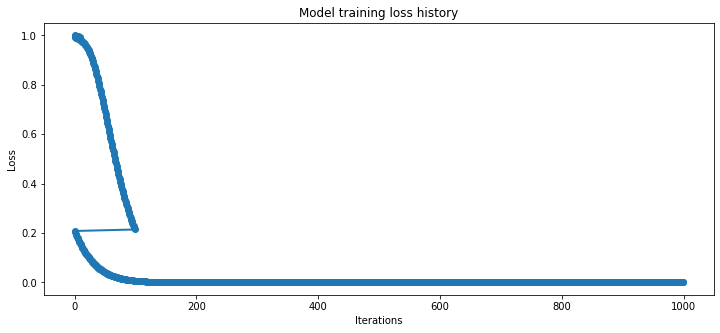

In [623]:
cfm.plot_loss()

In [625]:
embeddings_dict = cfm.get_embeddings
user_emb, product_emb = embeddings_dict.values()
user_emb, product_emb = user_emb.numpy(), product_emb.numpy()
predictions = tf.matmul(user_emb, tf.transpose(product_emb)).numpy()

In [626]:
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):
    """Computes the scores of the candidates given a query.
    Args:
    query_embedding: a vector of shape [k], representing the query embedding.
    item_embeddings: a matrix of shape [N, k], such that row i is the embedding
      of item i.
    measure: a string specifying the similarity measure to be used. Can be
      either DOT or COSINE.
    Returns:
    scores: a vector of shape [N], such that scores[i] is the score of item i.
    """
    u = query_embedding
    V = item_embeddings
    if measure == COSINE:
        V = V / np.linalg.norm(V, axis=1, keepdims=True)
        u = u / np.linalg.norm(u)
    scores = u.dot(V.T)
    return scores

In [627]:
scores = compute_scores(user_emb, product_emb, measure=COSINE)

In [628]:
def recommend_products(user_id, k=100):
    user_product_scores = scores[user_id]
    user_locale_products = locale_product.copy()
    user_locale_products['user_scores'] = user_product_scores
    return list(user_locale_products.sort_values(by=['user_scores'], ascending=False).iloc[:k]['id'])

In [629]:
def get_ranking(user_id, k=100):
    reccos = recommend_products(user_id, k=k)
    true_product = locale_train_sess.iloc[user_id]['next_item']
    rank = np.where(reccos==true_product)[0]
    if rank.shape[0] == 0:
        return -1
    else:
        return rank[0] + 1

In [23]:
def random_predicitons(locale, sess_test_locale):
    random_state = np.random.RandomState(42)
    products = read_product_data().query(f'locale == "{locale}"')
    predictions = []
    for _ in range(len(sess_test_locale)):
        predictions.append(
            list(products['id'].sample(PREDS_PER_SESSION, replace=True, random_state=random_state))
        ) 
    sess_test_locale['next_item_prediction'] = predictions
    sess_test_locale.drop('prev_items', inplace=True, axis=1)
    return sess_test_locale

In [24]:
test_sessions = read_test_data(task)
predictions = []
test_locale_names = test_sessions['locale'].unique()
for locale in test_locale_names:
    sess_test_locale = test_sessions.query(f'locale == "{locale}"').copy()
    predictions.append(
        random_predicitons(locale, sess_test_locale)
    )
predictions = pd.concat(predictions).reset_index(drop=True)
predictions.sample(5)

,locale,next_item_prediction
300690,UK,"[B07XDY79PP, B0B33MVZ7C, B0B9HPZVHQ, B0948QWNQ..."
232426,UK,"[B07C8GM4H1, B000R32OKY, B0759VDBSM, 152476399..."
83969,DE,"[B09CQBRGH9, B0B94DZZLH, B09TZVCKHK, B08DP33Y5..."
42591,DE,"[B07W92BSY2, B0B7MH1MDP, B08CMPYH56, B07BN8LG7..."
171048,JP,"[B002TV1GOM, B0039XRN2I, B09HRY7X6R, B0BGBS559..."


## Validate predictions ✅

In [26]:
def check_predictions(predictions, check_products=False):
    """
    These tests need to pass as they will also be applied on the evaluator
    """
    test_locale_names = test_sessions['locale'].unique()
    for locale in test_locale_names:
        sess_test = test_sessions.query(f'locale == "{locale}"')
        preds_locale =  predictions[predictions['locale'] == sess_test['locale'].iloc[0]]
        assert sorted(preds_locale.index.values) == sorted(sess_test.index.values), f"Session ids of {locale} doesn't match"

        if check_products:
            # This check is not done on the evaluator
            # but you can run it to verify there is no mixing of products between locales
            # Since the ground truth next item will always belong to the same locale
            # Warning - This can be slow to run
            products = read_product_data().query(f'locale == "{locale}"')
            predicted_products = np.unique( np.array(list(preds_locale["next_item_prediction"].values)) )
            assert np.all( np.isin(predicted_products, products['id']) ), f"Invalid products in {locale} predictions"

In [27]:
check_predictions(predictions)

In [28]:
# Its important that the parquet file you submit is saved with pyarrow backend
predictions.to_parquet(f'submission_{task}.parquet', engine='pyarrow')

## Submit to AIcrowd 🚀

In [ ]:
# You can submit with aicrowd-cli, or upload manually on the challenge page.
!aicrowd submission create -c task-1-next-product-recommendation -f "submission_task1.parquet"